<a href="https://colab.research.google.com/github/JeongHanJun/Colab/blob/master/Training_Evaluation_with_built_in_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
inputs = keras.Input(shape = (784, ), name = 'digits')
x = layers.Dense(64, activation = 'relu', name = 'dense_1')(inputs)
x = layers.Dense(64, activation = 'relu', name = 'dense_2')(x)
outputs = layers.Dense(10, activation = 'softmax', name = 'predictions')(x)

model = keras.Model(inputs = inputs, outputs = outputs)

# 일반적인 end to end workflow는 아래와 같이 구성된다.
1. Training (훈련)
2. Validation on holdout set generated from the original training data ( 기존의 훈련 데이터에서 생성된 홀드아웃 세트에 대한 검증 )
3. Evaluation on the test data ( 테스트 데이터에 대한 평가 )

In [4]:
# MNIST DATA 사용
# 트트테테
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# 데이터 전처리
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

11501568/11490434 [==============================] - 0s 0us/step


### Training Configuration( optimizer, loss, metrics )  = 훈련구성( 최적화, 손식, 행렬구조 )

In [6]:
model.compile(
    optimizer = keras.optimizers.RMSprop(),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [keras.metrics.SparseCategoricalAccuracy()]
)

In [7]:
print('Fit model on training data')
history = model.fit(
    x_train,
    y_train,
    batch_size = 64,
    epochs = 2,
    validation_data = (x_val, y_val)
)

Fit model on training data
Epoch 1/2
782/782 [==============================] - 3s 3ms/step - loss: 0.3294 - sparse_categorical_accuracy: 0.9051 - val_loss: 0.1651 - val_sparse_categorical_accuracy: 0.9522
Epoch 2/2
782/782 [==============================] - 2s 3ms/step - loss: 0.1573 - sparse_categorical_accuracy: 0.9523 - val_loss: 0.1326 - val_sparse_categorical_accuracy: 0.9612


In [9]:
# 반환된 history 객체는 훈련중의 loss 및 metrics 값들의 기록을 보유한다.
history.history

{'loss': [0.3293772339820862, 0.15733088552951813],
 'sparse_categorical_accuracy': [0.9051399827003479, 0.9522600173950195],
 'val_loss': [0.16513775289058685, 0.13260582089424133],
 'val_sparse_categorical_accuracy': [0.9521999955177307, 0.9611999988555908]}

In [10]:
# 테스트 데이터에서 모델을 평가
print('Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size = 128)
print('test loss, test acc : ', results)
print()
print('Generate predictions for 3 samples')
predictions = model.predict(x_test[:3])
print('predictions shape : ', predictions.shape)

Evaluate on test data
79/79 [==============================] - 0s 2ms/step - loss: 0.1437 - sparse_categorical_accuracy: 0.9585
test loss, test acc :  [0.14372141659259796, 0.9585000276565552]

Generate predictions for 3 samples
predictions shape :  (3, 10)


# Workflow의 각 part에 대한 검토

#### compile()
- loss, metrics를 지정 및 최적화 하는 방법

In [12]:
model.compile(
    optimizer = keras.optimizers.RMSprop(learning_rate = 1e-3),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [keras.metrics.SparseCategoricalAccuracy()]
)

- metrics의 인수는 list이어야 한다.
- 모델에 여러개의 출력이 있는 경우, 각 출력에 대해 서로 다른 loss 및 metrics을 지정할 수 있다.
- 모델에 여러개의 출력이 있는 경우, 모델의 총 손실에 대한 각 출력의 기여도를 조정할 수 있다.
- 기본 설정에 만족하면 optimizer, loss, metrics를 문자열 식별자를 통해 바로가기로 지정할 수 있다.

In [13]:
model.compile(
    optimizer = 'rmsprop',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['sparse_categorical_accuracy']
)

- 나중에 재사용하기 위해 모델 정의와 컴파일 단계를 함수에 넣는다.
- 적어도 이 파일 안에서 여러번 호출할 것이며, 실제로 함수를 통해 반복사용을 하는것이 편한 부분이 많다.

In [14]:
def get_uncompiled_model():
  inputs = keras.Input(shape = (784,), name = 'digits')
  x = layers.Dense(64, activation = 'relu', name = 'dense_1')(inputs)
  x = layers.Dense(64, activation = 'relu', name = 'dense_2')(x)
  outputs = layers.Dense(10, activation = 'softmax', name = 'prediction')(x)
  model = keras.Model(inputs = inputs, outputs = outputs)
  return model

def get_compiled_model():
  model = get_uncompiled_model()
  model.compile(
      optimizer = 'rmsprop',
      loss = 'sparse_categorical_crossentropy',
      metrics = ['sparse_categorical_accuracy']
  )
  return model

### 다양한 옵션
- 일반적으로 필요한것은 이미 Keras API안에 존재할 가능성이 높으므로, 처음부터 자체적으로 이를 구현할 필요는 없다.

- Optimizer
  1. SGD() - Stochastic Gradient Descent
  2. RMSprop()
  3. Adam()
  4. etc

- Losses 
  1. MeanSquaredError() - 최소제곱오차
  2. KLDivergence() - Kullback-Leibler 차이
  3. CosineSimilarity() - 코사인 유사도 : 두 벡터간 각도를 이용해 측정된 벡터간의 유사도
  4. etc

- Metrics
  1. AUC() - AUC - ROC Curve 
    - ROC(Receiver Operating Characteristic) : 모든 임계값에서 분류 모델의 성능을 보여주는 그래프
    - AUC(Area Under the Curve) : ROC 곡선 아래의 영역
    - AUC가 높다 = 클래스를 구별하는 모델의 성능이 좋다
    - 클래스를 구분하는 모델의 성능평가로 많이 사용한다.
  
  2. Precision()
    - 정밀도 : TP / (TP + FP)
    - Precision = Positive 정답률 = Positive Predictive Value
    - 모델이 True라고 분류한 것들 중에서 실제로 True인 것들의 비율
    
  3. Recall()
    - 재현율 : TP / (TP + FN)
    - Recall = sensitivity = hit rate
    - 실제 True인 것들 중에서 모델이 True라고 분류한 것들의 비율
  4. etc
  
  2+3 Precision-Recall Trade-off

  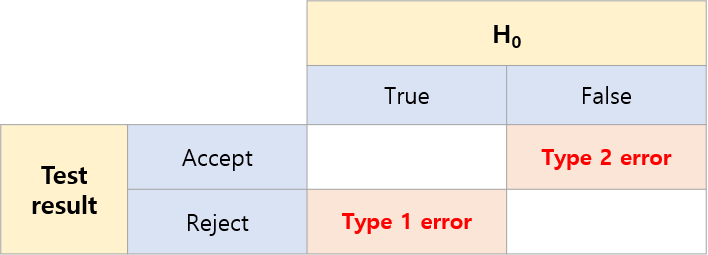

- 위 table 에서의 Type1 error 와 Type 2 error는 trade off 관계에 있다.

# Type 1 error = P( reject H0 | H0 == True)

# Type 2 error = P( accept H0 | H0 != True)

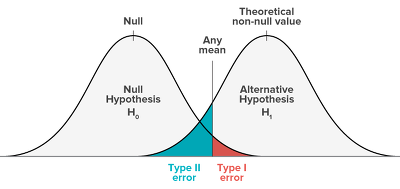

- 위 그림에서 Any mean이 기준점이고, H0 관점에서, 빨간색 영역을 줄이면, 파란색 영역이 커진다.
- 반대로 파란색 영역을 줄이면, 빨간색 영역이 커진다.
- 이러한 둘의 관계를 Trade-Off, 상충관계라고 한다.
- 이러한 이유는, Precision 과 Recall은 둘다 TP룰 분자로 한다.
- 그러나 분모는 TP+FN / TP+FP이다. 
- 이 때, FN과 FP는 각각 Type 1 error, Type 2 error에 있으므로 Trade-Off관계이다.
- 이에 따라, Precision 과 Recall 또한 Trade-Off 관계에 있다.

#### with Venn-diagram ( 벤 다이어그램 시각화 )

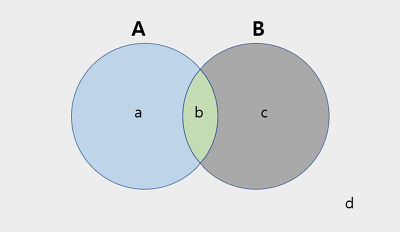

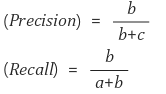

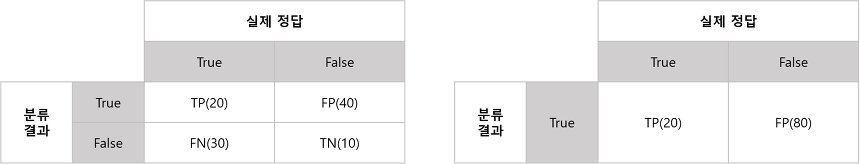

- 왼쪽의(일반적인) 경우 Recall = 20 / 50 = 40% , precision = 20 / 60 = 33.3%이다.
- 오른쪽의 경우  FN = 0 이므로 100% 이지만, FP가 늘어서 precision = 20 / 100 = 20%이다.



## Custom loss ( 맞춤 손실 )

In [16]:
def custom_mean_squared_error(y_true, y_pred):
  return tf.math.reduce_mean(tf.square(y_true - y_pred))


model = get_uncompiled_model()
model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = custom_mean_squared_error
)

y_train_one_hot = tf.one_hot(y_train, depth = 10)
model.fit(x_train, y_train_one_hot, batch_size = 64, epochs = 1)

782/782 [==============================] - 3s 3ms/step - loss: 0.0163


### 맞춤 측정항목 및 사용자 지정 metrics
- __init__(self) : metrics에 대한 상태 변수 생성
- update_state(self, y_true, y_pred, sample_weight = None) : y_true와 y_pred를 사용하여 상태 변수를 업데이트한다.
- result(self) : 상태 변수를 사용하여 최종 결과를 계산한다.
- reset_states(self) : 측정 항목의 상태를 다시 초기화한다.

In [19]:
class CategoricalTP(keras.metrics.Metric):

  def __init__(self, name = 'categorical_true_positives', **kwargs):
    super(CategoricalTP, self).__init__(name = name, **kwargs)
    self.true_positives = self.add_weight(name = 'ctp', initializer = 'zeros')
  
  def update_state(self, y_true, y_pred, sample_weight = None):
    y_pred = tf.reshape(tf.argmax(y_pred, axis = 1), shape = (-1, 1))
    values = tf.cast(y_true, 'int32') == tf.cast(y_pred, 'int32')
    values = tf.cast(values, 'float32')
    if sample_weight is not None:
      sample_weight = tf.cast(sample_weight, "float32")
      values = tf.multiply(values, sample_weight)
    self.true_positives.assign_add(tf.reduce_sum(values))

  def result(self):
    return self.true_positives

  def reset_states(self):
    self.true_positives.assign(0.0)


model = get_uncompiled_model()
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CategoricalTP()],
)
model.fit(x_train, y_train, batch_size=64, epochs=3)

Epoch 1/3
782/782 [==============================] - 3s 3ms/step - loss: 0.3382 - categorical_true_positives: 45189.0000
Epoch 2/3
 54/782 [=>............................] - ETA: 2s - loss: 0.1718 - categorical_true_positives: 3275.0000

/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric CategoricalTP implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


782/782 [==============================] - 2s 3ms/step - loss: 0.1538 - categorical_true_positives: 47690.0000
Epoch 3/3
782/782 [==============================] - 2s 2ms/step - loss: 0.1145 - categorical_true_positives: 48289.0000
